# Evaluation Metrics

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("telco_customer_churn.csv")

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [14]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state = 1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state = 1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [16]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [18]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

In [20]:
categorical = [ 
        'gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod'
]

In [22]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical+numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [24]:
val_dict = df_val[categorical+numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred > 0.5)
(y_val == churn_decision).mean()

0.8019872249822569

## Accuracy and Dummy Model

- Evaluate the model on different thresholds
- Check accuracy of dummy baselines

In [27]:
from sklearn.metrics import accuracy_score

len(y_val)

1409

In [29]:
(y_val == churn_decision).sum()

1130

In [31]:
thresholds = np.linspace(0, 1, 21) #churn decision thresholds

scores =[]

for t in thresholds:
    score = accuracy_score(y_val, y_pred >=t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.505
0.10 0.591
0.15 0.665
0.20 0.709
0.25 0.740
0.30 0.762
0.35 0.770
0.40 0.786
0.45 0.793
0.50 0.802
0.55 0.801
0.60 0.796
0.65 0.784
0.70 0.764
0.75 0.744
0.80 0.732
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


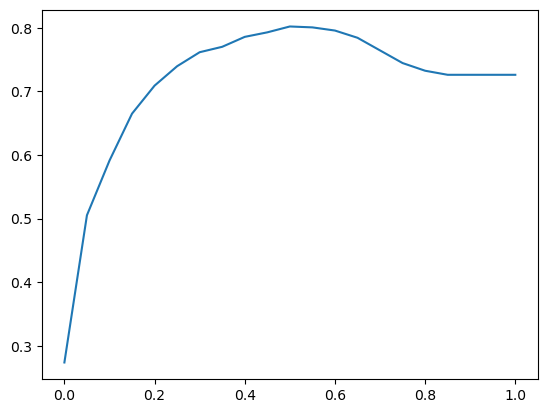

In [33]:
plt.plot(thresholds, scores)

In [35]:
#confirm how many values > 1 or less than 0
from collections import Counter

Counter(y_pred >= 1.0)

Counter({False: 1409})

In [39]:
Counter(y_val)

Counter({0: 1023, 1: 386})

There is **class imbalance** present in this dataset as there are 3x as many non churning individuals than churning.

Meaning that Accuracy Score can be quite misleading, as y_pred >= 1.0 would already have a good accuracy score due to the nature of the data setup

## Confusion Table

**Shows: True Positives, True Negatives, False Positives and False Negatives**

- different types of errors and correct decisions
- arranging them in a table

In [51]:
actual_positive = (y_val == 1)
actual_negative = (y_val == 0)

In [53]:
t = 0.5

predict_positive = (y_pred > t)
predict_negative = (y_pred < t)

In [63]:
tp = (predict_positive & actual_positive).sum() #Total True Positives
tn = (predict_negative & actual_negative).sum() #Total True Negatives

In [65]:
fp = (predict_positive & actual_negative).sum() #Total False Positives
fn = (predict_negative & actual_positive).sum() #Total False Negatives

In [71]:
#matrix setup - columns = predictions, rows = actual
#tn, fp
#fn, tp

confusion_matrix = np.array([
    [tn, fp],
    [fn, tp]
])
confusion_matrix

array([[920, 103],
       [176, 210]])

In [75]:
confusion_matrix / confusion_matrix.sum() #confusion matrix in percentage format

array([[0.65294535, 0.07310149],
       [0.12491128, 0.14904187]])

In [84]:
((tp + tn) / (tp + tn + fp  + fn)).round(2)

0.8

Total Accuracy = tp + tn = 15% + 65% = 80%

Gives a better understanding of the correct & incorrect decisions our model is making

## Precision and Recall

**Precision** = Fraction of Positive Predictions That Are Correct. 
TP / (TP + FP)

**Recall** = Fraction of Correctly Identified Positive Examples. 
TP / (TP + FN)

In [88]:
p = tp / (tp + fp)
p

0.670926517571885

In [94]:
r = tp / (tp + fn)
r

0.5440414507772021

Accuracy Score is 80%, but actually when we look at Precision and Recall the Model isn't that good!

Precision and recall really useful when there is a class imbalance

## ROC Curves

Receiver Operating Characteristic Curves.

**False Positive Rate & True Positive Rate are Key Metrics**

**False Positive Rate** = FP / TN + FP → False Positives / Total Negatives

**True Positive Rate** = TP / FN + TP → True Positives / Total Positives

We want to:

**MINIMISE** False Positive Rate 

**MAXIMISE** True Positive Rate

In [117]:
#FPR
fpr = fp / (tn + fp)
fpr

0.10068426197458455

In [119]:
#TPR
tpr = tp / (fn + tp)
tpr

0.5440414507772021

ROC Curve looks at these values for all possible thresholds

In [122]:
thresholds  = np.linspace(0, 1, 101)

scores = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    scores.append((t, tp, fp, tn, fn))
    

In [137]:
columns = ['threshold', 'tp', 'fp', 'tn', 'fn']
df_scores = pd.DataFrame(scores, columns=columns)

In [141]:
df_scores[::10] #View every 10th record

,threshold,tp,fp,tn,fn
0,0.0,386,1023,0,0
10,0.1,366,556,467,20
20,0.2,333,357,666,53
30,0.3,287,237,786,99
40,0.4,249,165,858,137
50,0.5,210,103,920,176
60,0.6,150,52,971,236
70,0.7,73,19,1004,313
80,0.8,10,1,1022,376
90,0.9,0,0,1023,386


In [143]:
df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)
df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)

In [147]:
df_scores[::10]

,threshold,tp,fp,tn,fn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,366,556,467,20,0.948187,0.543500
20,0.2,333,357,666,53,0.862694,0.348974
30,0.3,287,237,786,99,0.743523,0.231672
40,0.4,249,165,858,137,0.645078,0.161290
50,0.5,210,103,920,176,0.544041,0.100684
60,0.6,150,52,971,236,0.388601,0.050831
70,0.7,73,19,1004,313,0.189119,0.018573
80,0.8,10,1,1022,376,0.025907,0.000978
90,0.9,0,0,1023,386,0.000000,0.000000


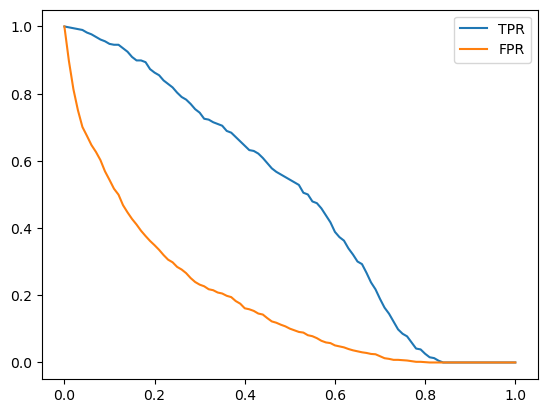

In [149]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Random Model

In [154]:
np.random.seed(1)
y_rand = np.random.uniform(0,1, size=len(y_val))

In [156]:
y_rand.round(3)

array([0.417, 0.72 , 0.   , ..., 0.774, 0.334, 0.089])

In [158]:
((y_rand >= 0.5) == y_val).mean()

0.5017743080198722

In [160]:
def tpr_fpr_dataframe(y_val, y_pred):
    thresholds  = np.linspace(0, 1, 101)

    scores = []
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
    
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        scores.append((t, tp, fp, tn, fn))

    columns = ['threshold', 'tp', 'fp', 'tn', 'fn']
    df_scores = pd.DataFrame(scores, columns=columns)

    df_scores['tpr'] = df_scores.tp / (df_scores.fn + df_scores.tp)
    df_scores['fpr'] = df_scores.fp / (df_scores.tn + df_scores.fp)

    return df_scores
                                

In [162]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

In [166]:
df_rand[::10]

,threshold,tp,fp,tn,fn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,347,923,100,39,0.898964,0.902248
20,0.2,307,822,201,79,0.795337,0.803519
30,0.3,276,724,299,110,0.715026,0.707722
40,0.4,237,624,399,149,0.613990,0.609971
50,0.5,202,518,505,184,0.523316,0.506354
60,0.6,161,409,614,225,0.417098,0.399804
70,0.7,121,302,721,265,0.313472,0.295210
80,0.8,78,206,817,308,0.202073,0.201369
90,0.9,40,101,922,346,0.103627,0.098729


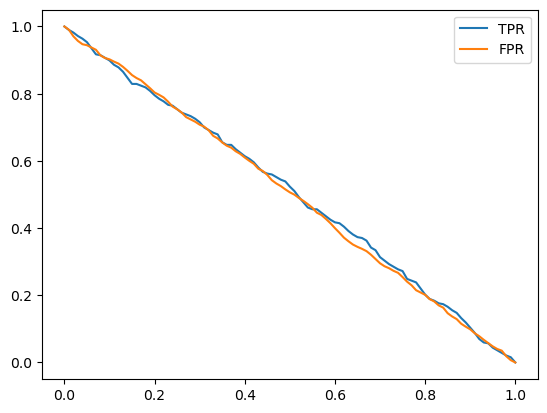

In [168]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

## Ideal Model

In [174]:
#Find number of non churning customers

num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_neg, num_pos

(1023, 386)

Want to sort customers so that all non churning come first and then followed by churners so that it has 100% accuracy on cut off

In [179]:
y_ideal = np.repeat([0, 1], [num_neg, num_pos]) #array contains exact number of positives and negatives in validation set
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [183]:
y_ideal_pred = np.linspace(0, 1, len(y_val))

In [189]:
1 - y_val.mean()

0.7260468417317246

In [187]:
((y_ideal_pred >= 0.726) == y_ideal).mean()

1.0

In [191]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

In [193]:
df_ideal[::10]

,threshold,tp,fp,tn,fn,tpr,fpr
0,0.0,386,1023,0,0,1.000000,1.000000
10,0.1,386,882,141,0,1.000000,0.862170
20,0.2,386,741,282,0,1.000000,0.724340
30,0.3,386,600,423,0,1.000000,0.586510
40,0.4,386,459,564,0,1.000000,0.448680
50,0.5,386,319,704,0,1.000000,0.311828
60,0.6,386,178,845,0,1.000000,0.173998
70,0.7,386,37,986,0,1.000000,0.036168
80,0.8,282,0,1023,104,0.730570,0.000000
90,0.9,141,0,1023,245,0.365285,0.000000


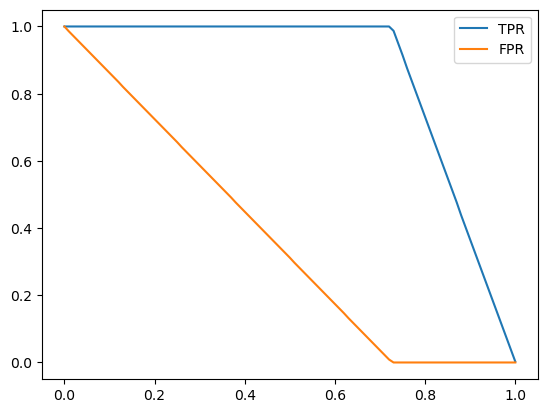

In [195]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()

### Putting everything together

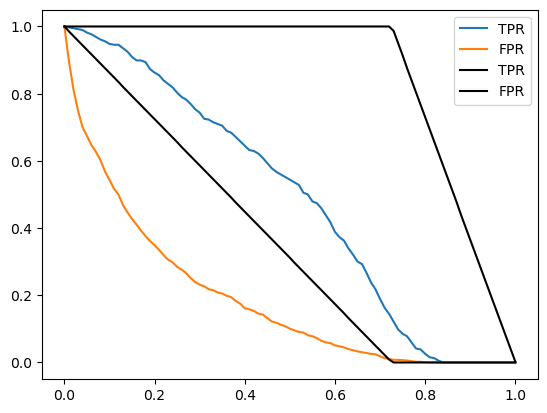

In [200]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR', color = 'black')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR', color = 'black')
plt.legend()

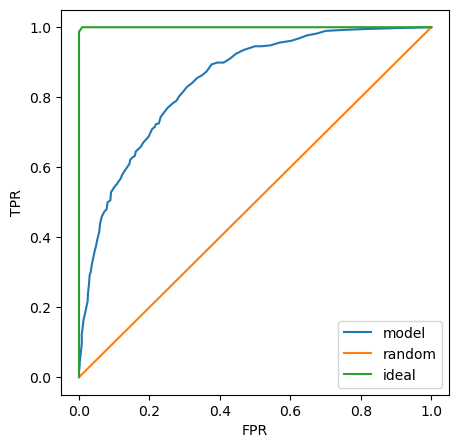

In [218]:
#plot Fpr against Tpr

plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

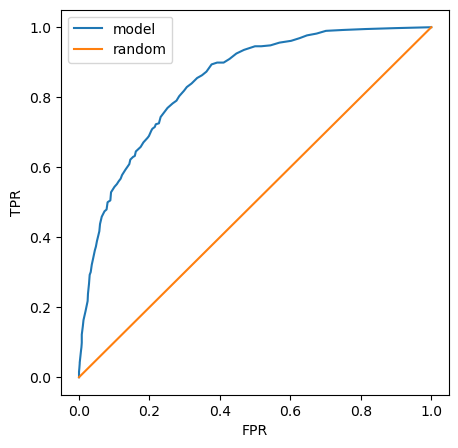

In [214]:
#plot Fpr against Tpr

plt.figure(figsize=(5,5))

plt.plot(df_scores.fpr, df_scores.tpr, label='model')
plt.plot([0,1], [0,1], label='random')
# plt.plot(df_rand.fpr, df_rand.tpr, label='random')
# plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

Bottom corner (0,0) = We do not predict anyone as churning False Positives and True Positives not Present.

Top Corner (1,1) = 100% TPR, as predict everyone as churning. Also make a lot of mistakes, hence False Postive Rate of 100%

As we move the threshold, we are predicting more customers as churning, thats why both TPR & FPR increasing.

The closer the line is to the ideal model, the better. the closer it is to the random model, the worse it is.

If ROC Curve is below random model line, there is an issue in the data analysis.


### Sci-kit learnt to plot ROC Curves

In [223]:
from sklearn.metrics import roc_curve

In [227]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

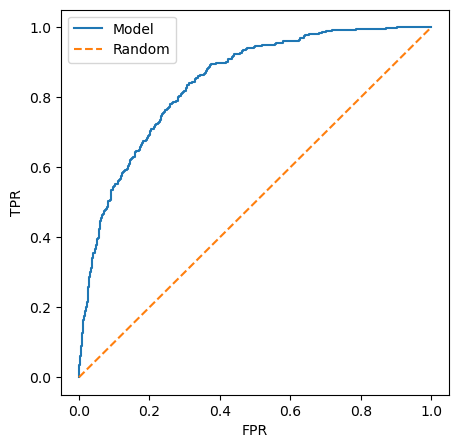

In [233]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label = 'Model')
plt.plot([0,1], [0,1], label = 'Random', linestyle = '--')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
plt.show()


### ROC AUC

- Area under the ROC curve - useful metric for binary classification models
- Getting average prediction and spread within predictions

Closer Area Under The Curve is to the Ideal Models', the better the Model. 

Ideal AUC = 1

Random AUC = 0.5

Model must have AUC ~ 0.5 < AUC < 1.


In [240]:
from sklearn.metrics import auc

In [244]:
auc(fpr, tpr) #Area under curve for model

0.8436377817958964

In [246]:
auc(df_ideal.fpr, df_ideal.tpr) #Area under curve for ideal

0.9999430203759136

In [248]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [250]:
from sklearn.metrics  import roc_auc_score

In [254]:
roc_auc_score(y_val, y_pred)

0.8436377817958964

In [258]:
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

AUC IS SIMPLY: Probability randomly selected positive example has higher score than randomly selected negative example

In [260]:
import random

In [264]:
n = 100000
success = 0


for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)
    
    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84345

In [295]:
#can do this in numpy in a random vectorised way

n=10000
np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size = n)
neg_ind = np.random.randint(0, len(neg), size = n)

(pos[pos_ind] > neg[neg_ind]).mean()

0.8407

## Cross-Validation

- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

K - Fold Cross Validation: Use full train & test datsets

Split Full Train into k parts, train data on k-1 sections and validate on section not trained, Continuously. 

Mean & Standard Deviation of AUC's for the k training modules are returned. 


In [326]:
def train(df, y):
    dicts = df[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X = dv.fit_transform(dicts)

    model = LogisticRegression()
    model.fit(X, y)

    return dv, model

In [328]:
dv, model = train(df_train, y_train)

In [330]:
def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [332]:
y_pred = predict(df_val, dv, model)
y_pred

array([0.00937688, 0.20636533, 0.21350024, ..., 0.14016521, 0.79757378,
       0.83465231])

In [334]:
from sklearn.model_selection import KFold

In [336]:
kfold = KFold(n_splits=10, shuffle=True, random_state=1)

In [360]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [362]:
#double chek that validation set is 10% and training is 90%
len(train_idx),  len(val_idx) 

(5070, 564)

In [364]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [366]:
scores =[]

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.churn.values
    y_val = df_val.churn.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

In [382]:
np.mean(scores), np.std(scores)

(0.841278066293736, 0.01237879619644706)

In [388]:
print('auc = %0.3f ± %0.3f' % (np.mean(scores), np.std(scores)))

auc = 0.841 ± 0.012


#### Parameter Tuning

In [391]:
def train(df, y, C=1.0):
    dict = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(dict)

    X = dv.transform(dict)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [403]:
n_splits = 5
kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

for C in [0.001, 0.01, 0.1, 0.5, 1, 5, 10]:
    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.churn.values
        y_val = df_val.churn.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(scores), np.std(scores)))

C=0.001, auc = 0.825 ± 0.013
C=0.01, auc = 0.840 ± 0.009
C=0.1, auc = 0.841 ± 0.007
C=0.5, auc = 0.841 ± 0.007
C=1, auc = 0.841 ± 0.007
C=5, auc = 0.841 ± 0.007
C=10, auc = 0.841 ± 0.007


In [407]:
#select C= 1
dv, model = train(df_full_train, df_full_train.churn.values, C=1.0)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8579400803839363